In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
import string
import re

from tqdm import tqdm
# initialize tqdm for pandas
tqdm.pandas()

# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# # nltk.download('stopwords')
# # nltk.download('wordnet')
# from fuzzywuzzy import fuzz

from helpers import *
# turn off the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Define Path

In [2]:
DIR = os.getcwd()

# raw data
RAW = "\data\\raw"
PATH_DF_CHANNELS = DIR + RAW + '\\df_channels_en.tsv.gz' # 6 mb
PATH_DF_TIMESERIES = DIR + RAW + '\\df_timeseries_en.tsv.gz' # 571 mb
PATH_YT_METADATA = DIR + RAW + '\\yt_metadata_en.jsonl.gz' # 13.6 gb
PATH_NUM_COMMENTS = DIR + RAW + '\\num_comments.tsv.gz' # 754 mb

# clean data
CLEAN = "\data\\clean"
PATH_YT_TECH_EDU_METADATA = DIR + CLEAN + '\\yt_tech_edu_metadata_en.tsv.gz'
PATH_TECH_CHANNELS = DIR + CLEAN + '\\tech_review_channels.tsv.gz'
PATH_TECH_VIDEOS = DIR + CLEAN + '\\tech_review_videos.tsv.gz'

# Preprocessing(Filter Tech Review channels)

### Metadata (filter 'Science & Education' videos)

In [3]:
# filter metadata
dfs = []
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date"], inplace=True, axis=1)
    df_json = df_json[(df_json['categories'] == 'Education') | (df_json['categories'] == 'Science & Technology')]
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    
    dfs.append(df_json)
yt_metadata = pd.concat(dfs)

# add number of comments
num_comments = pd.read_csv(PATH_NUM_COMMENTS, compression="infer", sep="\t")
yt_metadata = pd.merge(yt_metadata, num_comments, on='display_id', how='left')

# store
yt_metadata.to_csv(PATH_YT_TECH_EDU_METADATA, sep="\t", index=False, compression="infer")
# yt_metadata = pd.read_csv(PATH_YT_TECH_EDU_METADATA, sep="\t", compression="infer")

Loading data: 730it [30:54,  2.54s/it]                                                                                 


### Select most popular tech review channels' videos

In [4]:
# read channels dataset
df_channels = pd.read_csv(PATH_DF_CHANNELS, compression="infer", sep="\t")

# select the most popular tech review channels
popular_tech_channels = ['Marques Brownlee','Mrwhosetheboss','iJustine','UrAvgConsumer',
                         'Unbox Therapy','Linus Tech Tips','The Tech Chap','MrMobile [Michael Fi...']
popular_tech_channels_id = df_channels[df_channels.name_cc.isin(popular_tech_channels)].channel.unique()

# select the videos of the most popular tech review channels
popular_tech_channels_videos = yt_metadata[yt_metadata.channel_id.isin(popular_tech_channels_id)][['tags','title']]

### Find the most commonly used words both in tags and titles

In [5]:
# clean title and tags features
print('Cleaning title')
popular_tech_channels_videos['clean_title'] = popular_tech_channels_videos.title.progress_apply(clean_text)
print('Cleaning tags')
popular_tech_channels_videos['clean_tags'] = popular_tech_channels_videos.tags.progress_apply(clean_text)

# create a single list for all the words in both tags and titles
all_tags = []
all_titles = []
for tags in popular_tech_channels_videos.clean_tags.values:
    all_tags += tags
for titles in popular_tech_channels_videos.clean_title.values:
    all_titles += titles

Cleaning title


100%|███████████████████████████████████████████████████████████████████████████| 10234/10234 [00:15<00:00, 647.29it/s]


Cleaning tags


100%|███████████████████████████████████████████████████████████████████████████| 10234/10234 [00:48<00:00, 209.59it/s]


In [10]:
# select only the features 'channel_id','display_id','duration','tags','title'
yt_tech_review = yt_metadata[['channel_id','display_id','duration','tags','title']]

# clean title and tags
yt_tech_review['clean_title'] = yt_tech_review.title.progress_apply(clean_text)
yt_tech_review['clean_tags'] = yt_tech_review.tags.progress_apply(clean_text)

100%|████████████████████████████████████████████████████████████████████| 6198568/6198568 [10:05:14<00:00, 170.69it/s]


#### Method 1

In [6]:
# get the most commonly used words in tags and titles
tags_common = get_common_words(all_tags).rename({'word':'tags_unique','occurance':'tags_prob'},axis=1)
titles_common = get_common_words(all_titles).rename({'word':'titles_unique','occurance':'titles_prob'},axis=1)

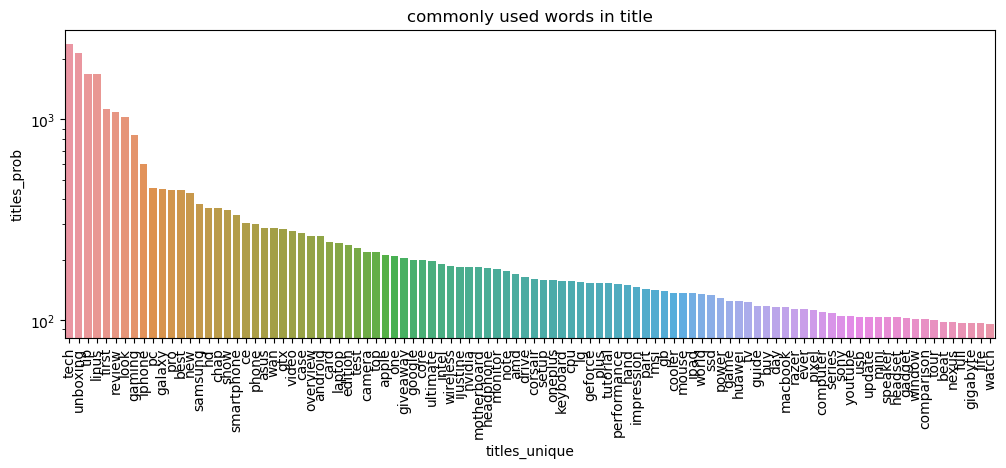

In [7]:
# plot the most commonly used words in titles
plt.figure(figsize=(12,4))
sns.barplot(x = titles_common.titles_unique, y = titles_common.titles_prob)
plt.xticks(rotation=90)
plt.title('commonly used words in title')
plt.yscale('log')
plt.show()

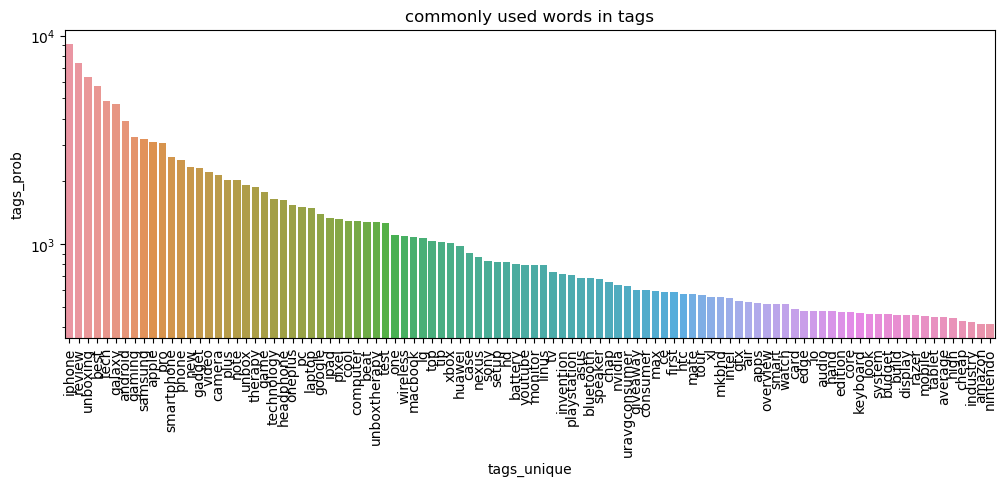

In [8]:
# plot the most commonly used words in tags
plt.figure(figsize=(12,4))
sns.barplot(x = tags_common.tags_unique, y = tags_common.tags_prob)
plt.xticks(rotation=90)
plt.title('commonly used words in tags')
plt.yscale('log')
plt.show()

In [11]:
# count the number of occurances of the most commonly used words in tags and titles in the tags and title of each video
yt_tech_review['tags_occurances_perc'] = yt_tech_review['clean_tags'].apply(lambda tags: 0 if len(tags) == 0 else (np.intersect1d(tags, tags_common['tags_unique'].unique()).shape[0] / len(tags)))
yt_tech_review['title_occurances_perc'] = yt_tech_review['clean_title'].apply(lambda title: 0 if len(title)==0 else (np.intersect1d(title,titles_common['titles_unique'].unique()).shape[0] / len(title)))

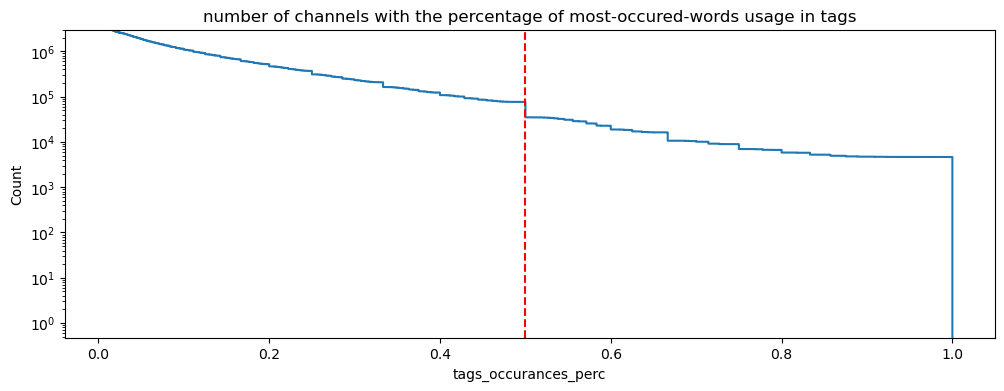

In [12]:
# plot the number of channels with the percentage of most-occured-words usage in tags
plt.figure(figsize=(12,4))
sns.ecdfplot(x = yt_tech_review[yt_tech_review.tags_occurances_perc > 0].tags_occurances_perc, complementary=True, stat='count', log_scale=(False, True))
plt.axvline(x=0.5, color='red', linestyle='--')
plt.title('number of channels with the percentage of most-occured-words usage in tags')
plt.show()

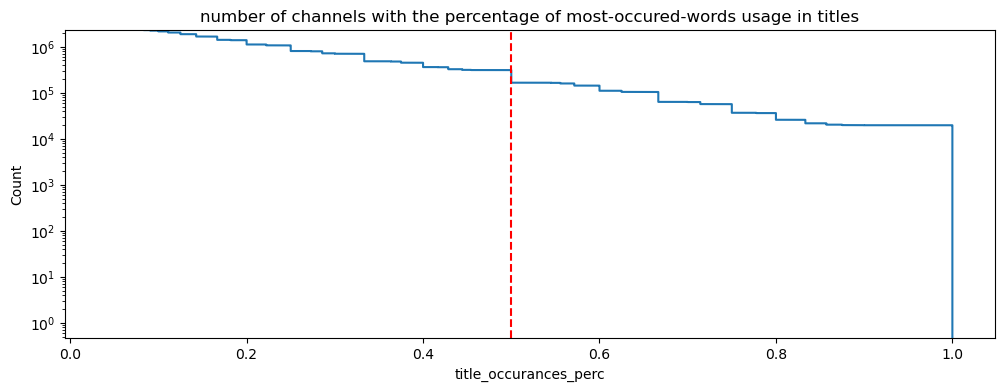

In [13]:
# plot the number of channels with the percentage of most-occured-words usage in titles
plt.figure(figsize=(12,4))
sns.ecdfplot(x = yt_tech_review[yt_tech_review.title_occurances_perc > 0].title_occurances_perc, complementary=True, stat='count', log_scale=(False, True))
plt.axvline(x=0.5, color='red', linestyle='--')
plt.yscale('log')
plt.title('number of channels with the percentage of most-occured-words usage in titles')
plt.show()

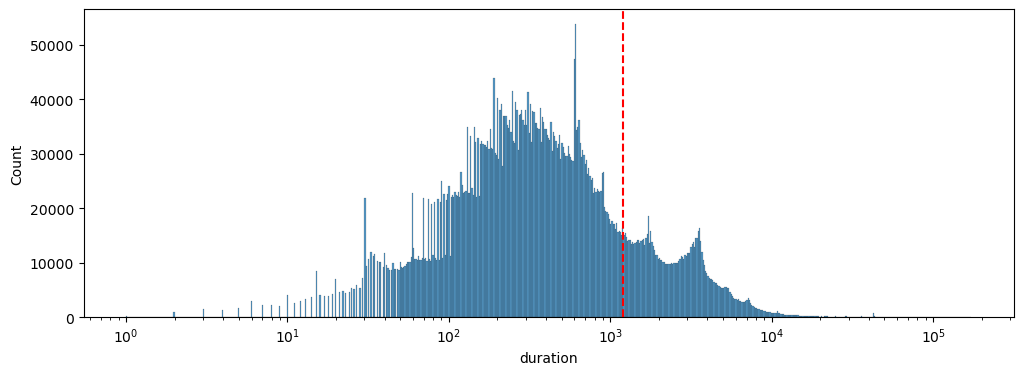

In [14]:
# plot the duration of videos
plt.figure(figsize=(12,4))
sns.histplot(x = yt_tech_review.duration, stat='count', log_scale=True)
plt.axvline(x=1200, color='red', linestyle='--')
plt.show()

In [27]:
# tech review videos only
tech_review_videos = yt_tech_review[(yt_tech_review.duration < 1200) & ((yt_tech_review.tags_occurances_perc > 0.5) | (yt_tech_review.title_occurances_perc > 0.5))]

# store tech review videos dataset with clean title/tags
pd.merge(
     yt_metadata[yt_metadata.display_id.isin(tech_review_videos.display_id.unique())].drop('categories',axis=1), 
     tech_review_videos[['clean_title','clean_tags','display_id']], 
     on='display_id', 
     how='left'
).reset_index(drop=True).to_csv(PATH_TECH_VIDEOS, sep="\t", index=False, compression="infer")

In [28]:
tech_review_videos.shape

(178255, 9)

#### Method 2 (tf idf)

In [23]:
"""
To be implemented
------------------
input: 
    yt_tech_review: yt_metadata with ['channel_id','display_id','duration','tags','title','clean_title','clean_tag']
    all_titles: words used in titles of the most popular tech review youtubers' videos 
    all_tags: words used in tags of the most popular tech review youtubers' videos
output:
    DataFrame of tech review videos only
""";

#### Method 3 (Bayesian)

In [24]:
"""
To be implemented
------------------
input: 
    yt_tech_review: yt_metadata with ['channel_id','display_id','duration','tags','title','clean_title','clean_tag']
    all_titles: words used in titles of the most popular tech review youtubers' videos 
    all_tags: words used in tags of the most popular tech review youtubers' videos
output:
    DataFrame of tech review videos only
""";

### Filter the tech review channels

In [16]:
# count the number of tech review videos per channel
count_tech_videos = tech_review_videos.groupby('channel_id',as_index=False)[['display_id']].count().rename({'display_id':'count_tech_videos'},axis=1)

# assign the number of tech review videos for each channel
df_tech_channels = pd.merge(df_channels.rename({'channel':'channel_id'},axis=1), count_tech_videos, how='left', on='channel_id')
df_tech_channels.loc[df_tech_channels.count_tech_videos.isna(), 'count_tech_videos'] = 0

# get the percentage of tech review videos
df_tech_channels['tech_videos_perc'] = df_tech_channels['count_tech_videos'] / df_tech_channels['videos_cc']

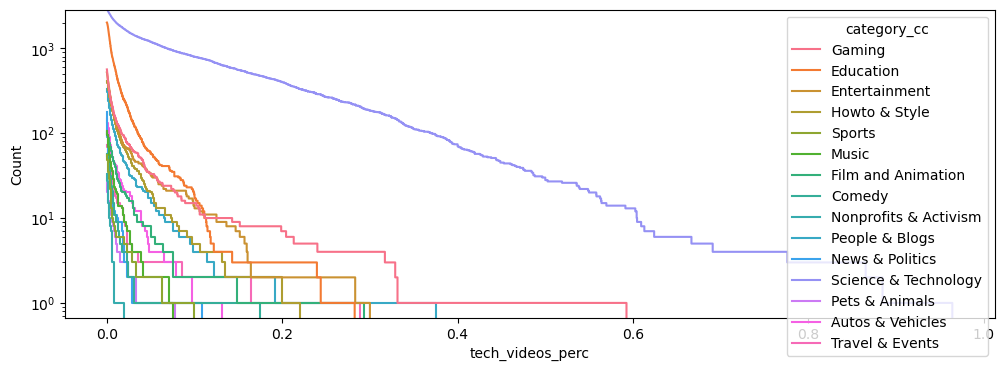

In [17]:
# plot the number of channels versus the percentage of tech review videos per channel for each category
plt.figure(figsize=(12,4))
sns.ecdfplot(x = df_tech_channels[df_tech_channels.tech_videos_perc > 0].tech_videos_perc, stat='count', complementary=True, hue=df_tech_channels.category_cc)
plt.yscale('log')
plt.show()

In [30]:
# tech review videos only
tech_review_channels = df_tech_channels[(df_tech_channels.tech_videos_perc > 0.05) & (df_tech_channels.category_cc == 'Science & Technology')]

# # store tech review channels dataset
tech_review_channels.drop(['category_cc','tech_videos_perc'],axis=1).reset_index(drop=True).to_csv(PATH_TECH_CHANNELS, sep="\t", index=False, compression="infer")

In [32]:
tech_review_channels.shape

(1193, 10)

### To do
- Store into a new dataframe with all the videos of the classified channels. Get those videos from raw yt_metadata